In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('fer2013.csv') #Reading the FER2013 dataset

In [4]:
fold_number = 5

In [5]:
data['KFold'] = range(len(data))
data['KFold'] = data['KFold']%fold_number
data.drop('Usage', inplace= True, axis= 1)

In [6]:
num_classes = 7
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [7]:
emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort = False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)

emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Disgust,547


Text(0.5, 0, 'Emotional Status')

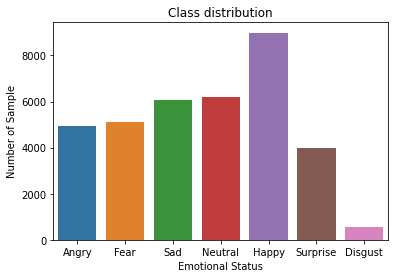

In [8]:
plt.figure()
# print('\n')
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number of Sample')
plt.xlabel('Emotional Status')

In [9]:
def CRNO(df):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    #pixel_sequence = df['pixels']
    #df['pixels'] = [int(pixel) for pixel in pixel_sequence.split()]
    data_X = np.array(df['pixels'].tolist(), dtype = 'float32').reshape(-1, width, height, 1)/255.0
    data_Y = to_categorical(df['emotion'], num_classes)
    return data_X, data_Y

In [10]:
data_generator = ImageDataGenerator(featurewise_center = False,
                                    featurewise_std_normalization = False,
                                    rotation_range = 20,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    zoom_range = 0.1,
                                    horizontal_flip = True)

es = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)
# es = EarlyStopping(monitor = 'val_accuracy', patience = 30, mode = 'max', restore_best_weights = True)

In [11]:
for kf in range(fold_number):
    data_train = data[data['KFold'] != kf].copy()
    data_val = data[data['KFold'] == kf].copy()
    
    # print(data_train.shape, data_val.shape)
    
    train_X, train_Y = CRNO(data_train)
    val_X, val_Y = CRNO(data_val)
    
    model = Sequential()

    #module 1
    model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding = 'same', input_shape=((width, height, 1)), data_format='channels_last'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    #module 2
    model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    #module 3
    model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    #flatten
    model.add(Flatten())

    #dense 1
    model.add(Dense(2*2*2*num_features))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    #dense 2
    model.add(Dense(2*2*num_features))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    #dense 3
    model.add(Dense(2*num_features))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    #output layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
                  metrics=['accuracy'])

    model.summary()
    
    history = model.fit(data_generator.flow(train_X, train_Y, batch_size),
                    steps_per_epoch = len(train_X) / batch_size,
                    epochs = num_epochs,
                    verbose = 2, 
                    callbacks = [es],
                    validation_data = (val_X, val_Y))
    
    model.evaluate(val_X, val_Y, verbose=1)
    
    pred_Y=model.predict(test_X)

    tesst_Y=np.argmax(test_Y, axis=1)
    pred_Y=np.argmax(pred_Y,axis=1)

    cmatrix=confusion_matrix(tesst_Y, pred_Y)
    cmatrix = cmatrix.astype('float')/cmatrix.sum(axis=1)[:, np.newaxis]

    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cmatrix, annot=True, fmt= '.2f', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 256)       2560      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 256)       1024      
_________________________________________________________________
activation (Activation)      (None, 48, 48, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 256)       590080    
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 256)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 256)       0

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Conv2D (defined at \AppData\Local\Temp/ipykernel_8236/330788477.py:69) ]] [Op:__inference_train_function_2865]

Function call stack:
train_function
